In this notebook, we demonstrate that we can successfully perform preprocessing of the PhysioNet dataset used for fine-tuning.

**Limitation**

In order to keep the runtime of the notebook tractable, we perform the preprocessing assuming the dataset is already extracted. This is different from the original code which performs extraction and preprocessing.

**Context**

The preprocessing for the PhysioNet dataset used for finetuning is inefficient.

The function the authors use is called `get_challenge17_data` ([source](https://github.com/myles-i/DLH_TransferLearning/blob/master/finetuning/datasets.py#L9)), and it does both extracting the data and performing preprocessing actions on it.

The problem is that the extraction portion takes a long time in Colab, approximately one hour on a CPU instance. This is likely due to overhead due to the raw PhysioNet data having lot of small files and the extraction code taking a relatively long time per file.

If we only run the whole data reading process one time, this is not an issue. However, we'd like the option to apply different preprocessing options such as padding length, sampling rate, etc.

Thus to make future experimentation faster, we make the extraction portion a one-time cost by splitting `get_challenge17_data` into two separate portions. One for extracting the data and saving it somewhere, the other to retrieve the extract data, apply preprocessing on it, and save it elsewhere.

Below we set up the environment.

In [61]:
%%capture
REPO = '/tmp/repo'
! git clone https://github.com/myles-i/DLH_TransferLearning.git $REPO
%cd $REPO

In [5]:
%%time
%%capture
!pip install -r requirements.txt

Now we define the two separate functions below.

In [11]:
import functools

import numpy as np

from finetuning import datasets
from transplant.datasets import physionet


def extract_challenge17_data(db_dir, verbose=False):
    # This is the author's extraction code
    records, labels = physionet.read_challenge17_data(db_dir, verbose=verbose)
    return records, labels


def process_extracted_challenge17_data(
    records, labels, fs=None, pad=None, normalize=False, verbose=False):
    """
    Args:
        records: See extract_challenge17_data
        labels: See extract_challenge17_data
        fs (int): Sampling rate
        pad (int): Length that each record should be padded to (or truncated)
            pad / fs will give the approximate length in seconds.
        normalize (bool): Whether to standardize the records using mean and s.d.
            computed over the entire dataset. Note that the mean and s.d. have
            already been provided by the authors.
    """
    if normalize:
        normalize = functools.partial(
            physionet.normalize_challenge17, inplace=True)
    data_set = datasets._prepare_data(
        records,
        labels,
        normalize_fn=normalize,
        fs=fs,
        pad=pad,
        verbose=verbose)
    return data_set

As mentioned, we do not perform extraction in this notebook. We describe the general procedure below.

First, you must download the PhysioNet data, which is found [here](https://physionet.org/content/challenge-2017/1.0.0/). Specifically, download the `train2017.zip` file and extract it somewhere.

```python
from transplant.utils import save_pkl
physionet_raw = '<location of extracted train2017.zip>'
# Recommend to set verbose=True to show progress bar
records, labels = extract_challenge17_data(physionet_raw, verbose=True)

out_dir = '<location to save the extracted records and labels>'
# Note: this saves the result to a dict {'data': records}
save_pkl(f"{out_dir}/records.pkl", data=records)
# Note: this saves the result to a dict {'data': records}
save_pkl(f"{out_dir}/records.pkl", data=labels)
```

Having said this, we will skip this part in this notebook and focus on the preprocessing part. We download the extracted data from our Google Drive folder.



In [60]:
%%time
%%capture
# get the pre-read physionet data
PREREAD_ID = '1lI7lTZltRj_zQtYM1UcidZnSAQilPJSg'
PREREAD_DIR = '/tmp/data/physionet_preread'
! rm -rf $PREREAD_DIR
! mkdir -p $PREREAD_DIR
! gdown $PREREAD_ID -O $PREREAD_DIR --folder

CPU times: user 41.4 ms, sys: 8.42 ms, total: 49.8 ms
Wall time: 3.03 s


In [17]:
! ls -lh $PREREAD_DIR

total 124M
-rw-r--r-- 1 root root  24K Apr 14 07:13 labels.pkl
-rw-r--r-- 1 root root 124M Apr 14 07:13 records.pkl


Next, we shall read these already-extracted files and apply preprocessing.

In [34]:
%%time
from transplant.utils import load_pkl

records = load_pkl(f"{PREREAD_DIR}/records.pkl")["data"]
labels = load_pkl(f"{PREREAD_DIR}/labels.pkl")["data"]
physionet_data = process_extracted_challenge17_data(
    records,
    labels,
    fs=250,
    pad=16384,
    normalize=True,
    verbose=True,
)

Resampling records: 100%|██████████| 8528/8528 [00:04<00:00, 1824.33it/s]


CPU times: user 5.28 s, sys: 1.39 s, total: 6.67 s
Wall time: 6.7 s


Note that the parameters to preprocessing are taken from the fine-tuning [README](https://github.com/myles-i/DLH_TransferLearning/blob/master/finetuning/README.md). What is happening is:

- Resampling the records to 250 Hz to match the Icentia11K dataset sample rate.
- Ensuring each record is about 65 seconds long. ($16384 / 250 \approx 65$)
- Standardize the data with the mean and standard deviation over the entire PhysioNet dataset. They are already computed [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/datasets/physionet.py#L12-L13).

Now we explore the data a little bit.

In [35]:
print(f'PhysioNet data summary:')
print(f'Number of samples: {len(physionet_data["x"])}')
print(f'Dimensions of a sample: {physionet_data["x"][0].shape}')

PhysioNet data summary:
Number of samples: 8528
Dimensions of a sample: (16384, 1)


Here is what a randomly selected ECG sample looks like.

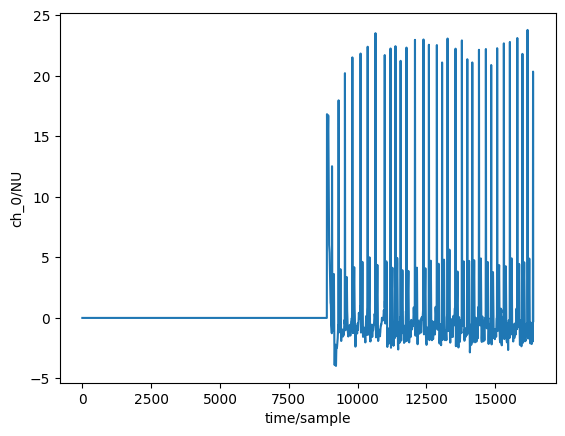

In [57]:
import wfdb
wfdb.plot_items(physionet_data['x'][3])

Here is what the labels look like for this example:

In [56]:
physionet_data['y'][3]

array([1, 0, 0, 0], dtype=uint8)

This is a one hot encoded array, and the locations correspond to the classes below, where the classes represent AF, Normal, Other, or Noise, respectively.

In [53]:
physionet_data['classes']

array(['A', 'N', 'O', '~'], dtype=object)

Next, we need to split the PhysioNet data into train and test sets. The paper uses 80% and 20% split, respectively. Also, the paper maintains the original class ratio in each set.

**Unlike the authors, we set a seed to ensure reproducability in our own work.**


In [59]:
from finetuning.utils import train_test_split

physionet_train, physionet_test = train_test_split(
    physionet_data, test_size=0.2, stratify=physionet_data['y'],
    # NEW: pass in random state for reproducibility
    random_state=2024,
)

In order to run fine-tuning, the data needs to be saved to disk. We do not do this here because we have already done this beforehand and saved the result to Google Drive.

Below is some sample code to do this.

```python
from transplant.utils import save_pkl

out_path = '<location of output directory>'
save_pkl(f'{out_path}/physionet_train.pkl', **physionet_train)
save_pkl(f'{out_path}/physionet_test.pkl', **physionet_test)
```


Now we cleanup.

In [62]:
del physionet_train
del physionet_test
del records
del labels